I found some cool artwork where a photo is triangulated, and then pulled into a 3D surface such that it looks "normal" when viewed from the front.

<http://www.pauldilena.com/hex-peony1.html>

It would be cool to create one of these and have some semi automated way to go from the original photo to the transformed paper. (that would then have to be cut and assembled)

Steps:
- Start with an image
- Create a (2D) triangulation of the picture.
- "Lift" the triangulation into 3D.
- For each triangle, extract the relevant image piece, transform it, amend / annotate, return new image piece.
- Arrange all of these pieces together in 2D so they can be printed and cut out.
- Produce a map of what goes where.

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt # for inline plotting

import cv2 # for processing

%matplotlib inline

In [2]:
# Convenience function for plotting.
def myimshow(cv2im, ax=None):
    
    img = cv2.cvtColor(cv2im, cv2.COLOR_BGR2RGB)
    
    if ax is None:
        fig = plt.figure(figsize=(8, 8))
        ax = fig.gca()

    ax.imshow(img)
    ax.set_xticks([])
    ax.set_yticks([])

## Look at our main image.

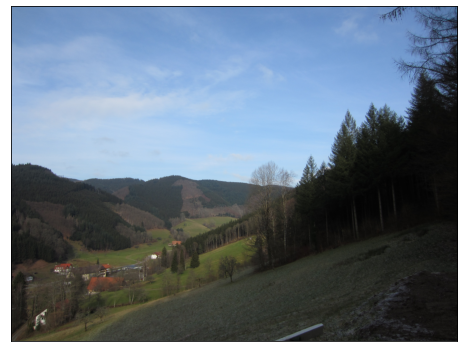

In [3]:
img = cv2.imread("./images/schwartzwald.jpg", 1) # int `1` is for a color picture.
myimshow(img)

In [4]:
# rect = cv2.boundingRect(points) # returns (x,y,w,h) of the rect
# cropped = res[rect[1]: rect[1] + rect[3], rect[0]: rect[0] + rect[2]]
# myimshow(cropped)

## Define some functions to cut triangles and stretch them.

In [32]:
def cut_triangle_from_image(im, tri2D):
    """Given an image `im` and a triangle in the plane `tri2D`, return just the triangular portion of the image.
    
    TODO: Check if the masked stuff is white or transparent."""
    
    height = im.shape[0]
    width = im.shape[1]

    mask = np.zeros((height, width), dtype=np.uint8)
    
    tri2D = np.int32(tri2D)
    
    cv2.fillPoly(mask, [tri2D], (255))

    res = cv2.bitwise_and(im, im, mask = mask)
    
    rect = cv2.boundingRect(tri2D) # returns (x,y,w,h) of the rect
    cropped = res[rect[1]: rect[1] + rect[3], rect[0]: rect[0] + rect[2]]
    
    return cropped


def tri3D_to_normal(tri3D):
    """
    Given a triangle in 3D, return the normal vector.
    
    tri3D : [[x0, y0, z0], [x1, y1, z1], [x2, y2, z2]]
    
    Choose the sign so that the z coordinate is positive.
    """
    # Get two "side" vectors and form cross product.
    
    sA = tri3D[1, :] - tri3D[0, :]
    sB = tri3D[2, :] - tri3D[0, :]
    
    n = np.cross(sA, sB)
    n = n / np.sum(n**2)**0.5
    
    # We want the normal to point in the positive z-direction.
    n /= np.sign(n[2])
    
    return n
    
    
def normal_to_stretch_vec(n):
    """
    Given a normal vector (normal to the desired 3D triangle) return the vector in 2D that, when applied as a stretch  
    to the original image, would yield a triangle that, when viewed straight on in 3D, projects to the original image.
    
    For example, if the normal vector is (0, 0, 1), the triangle is 'flat' and so the stretch vector is (1, 1) - 
    the identity.
    
    Another example, if the normal vector is (1, 0, 1)/sqrt(2), the triangle is rotated 45 degrees about the y axis.
    The extent in x will be reduced. To compensate for this, we require a stretch in x so the stretch vector is 
    (sqrt(2), 1).
    
    Note: normal vectors do not have to be unit length.
    """
    
    # as the normal goes from upright down toward the x axis, the x stretch factor goes from 1 to infinity
    
    stretch_x = (n[0]**2 + n[2]**2)**0.5 / n[2]
    stretch_y = (n[1]**2 + n[2]**2)**0.5 / n[2]
    
    return (stretch_x, stretch_y)
    
def stretch_image(im, stretch_vec):
    # TODO: Consider other interpolation methods.
    # TODO: Try skimage.transform.rescale
    
    # Note: you have to pass in a final size even if you are using stretch factors
    # Apparently (0,0) is OK for this.
    return cv2.resize(im, (0, 0), fx=stretch_vec[0], fy=stretch_vec[1], interpolation=cv2.INTER_AREA)
    
    
def get_skewed_triangle_image(im, tri3D):
    """Given an image `im` and a triangle in 3D `tri3D`, return the triangular face that if held in the location of 
    `tri3D` and viewed from above would look like the original image.
    
    im : 
    tri3D : [[x0, y0, z0], [x1, y1, z1], [x2, y2, z2]]
    """

    tri2D = tri3D[:, [0,1]]
    cropped = cut_triangle_from_image(im, tri2D)
    
    n = tri3D_to_normal(tri3D)
    stretch_vec = normal_to_stretch_vec(n)    
    
    return stretch_image(cropped, stretch_vec)

## Test out our cut and stretch functions.

3000 4000
3000 4000
n [-0.89442719 -0.          0.4472136 ]


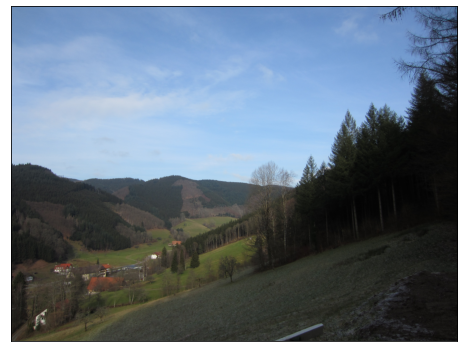

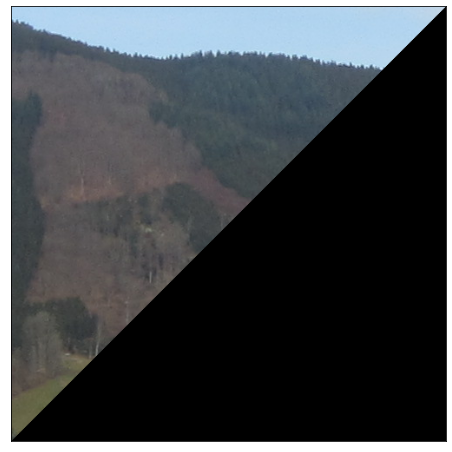

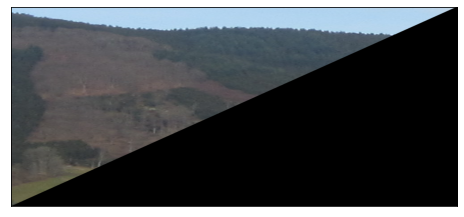

In [6]:
tri3D = np.array([[1500, 1500, 0], [1500, 2000, 0], [2000, 1500, 1000]])

tri_im = cut_triangle_from_image(img, tri3D[:, 0:2])
skewed_tri = get_skewed_triangle_image(img, tri3D)

myimshow(img)
myimshow(tri_im)
myimshow(skewed_tri)

## Now we need some way of creating the whole arrangment of triangles.

Let's do this in 2D and then lift to 3D in a separate step later.

In [7]:
from scipy.spatial import Delaunay

def hex_triangulation(shape, Nx=6, Ny=4, fill_edges=True):
    """
    Create a regular triangulation with dense triangles.
    
    Each triangle is isosceles where vertical midline is axis of symmetry.    
    
    Nx : number of triangles counting across
    Ny : number of triangles counting down
    
    """
    height = img.shape[0]
    width = img.shape[1]
    
    tri_width = width / Nx
    tri_height = height / Ny
    
    # Alternate between two types of horizontal rows.
    xsA = np.linspace(0, width, num=Nx + 1, endpoint=True)

    xsB = (xsA[:-1] + xsA[1:]) / 2
    xsB_fill_edges = np.array([0] + list(xsB) + [width])
    
    all_ys = np.linspace(0, height, num=Ny + 1, endpoint=True)
    
    xs = []
    ys = []
    
    # Construct the main triangular lattice
    for yind in range(Ny + 1):
        if yind % 2 == 0:
            xs.extend(xsA)
            ys.extend(all_ys[yind] * np.ones(Nx + 1))
        else:
            if fill_edges:
                xs.extend(xsB_fill_edges)
                ys.extend(all_ys[yind] * np.ones((Nx + 2)))
            else:
                xs.extend(xsB)
                ys.extend(all_ys[yind] * np.ones((Nx - 0)))
    
    points2D=np.vstack([xs, ys]).T
    tri = mpl.tri.Triangulation(xs, ys)

    return tri

def random_triangulation(shape):
    """Given an image shape, create a triangulation that consists of a regular array of equilateral triangles in a 
    hexagonal pattern where each triangle is then split into three equal sub-triangles.
    The height profile is such that each trio of sub-triangles forms a pyramid."""
    
    height = img.shape[0]
    width = img.shape[1]
    print(height, width)
    
    N = 100
    
    xs = np.random.uniform(low=0, high=width, size=N)
    ys = np.random.uniform(low=0, high=height, size=N)
    
    points2D=np.vstack([xs, ys]).T
    tri = Delaunay(points2D, incremental=True)
    
    return tri

In [8]:
def refine_each_triangle_to_3(tri):
    """Given a triangulation, return a refined triangulation where each triangle is turned into three.
    
    For each simplex, we find the center point, add it, remove the original simplex and replace it with the three 
    subtriangles."""
    
    num_triangles = len(tri.triangles) # Do we need to record this so we know what to cut later?
    
    new_xs = []
    new_ys = []
    
    new_triangles = []
    
    point_index = len(tri.x) # new points will have indices starting here
    
    for triangle in tri.triangles: # Each `triangle` is a list of indices (into x and y)
        center_x = np.sum(tri.x[triangle]) / 3
        center_y = np.sum(tri.y[triangle]) / 3
        
        new_xs.append(center_x)
        new_ys.append(center_y)
        
        # TODO: Do we need to worry about orientation here?
        new_triangles.append([point_index, triangle[0], triangle[1]])
        new_triangles.append([point_index, triangle[1], triangle[2]])
        new_triangles.append([point_index, triangle[2], triangle[0]])
        
        point_index += 1
    
    new_xs = np.array(new_xs)
    new_ys = np.array(new_ys)

    all_xs = np.append(tri.x, new_xs)
    all_ys = np.append(tri.y, new_ys)
    
    return mpl.tri.Triangulation(all_xs, all_ys, triangles=new_triangles)

## Test out the triangulations.

This is a fun experiment where we refine triangles iteratively.

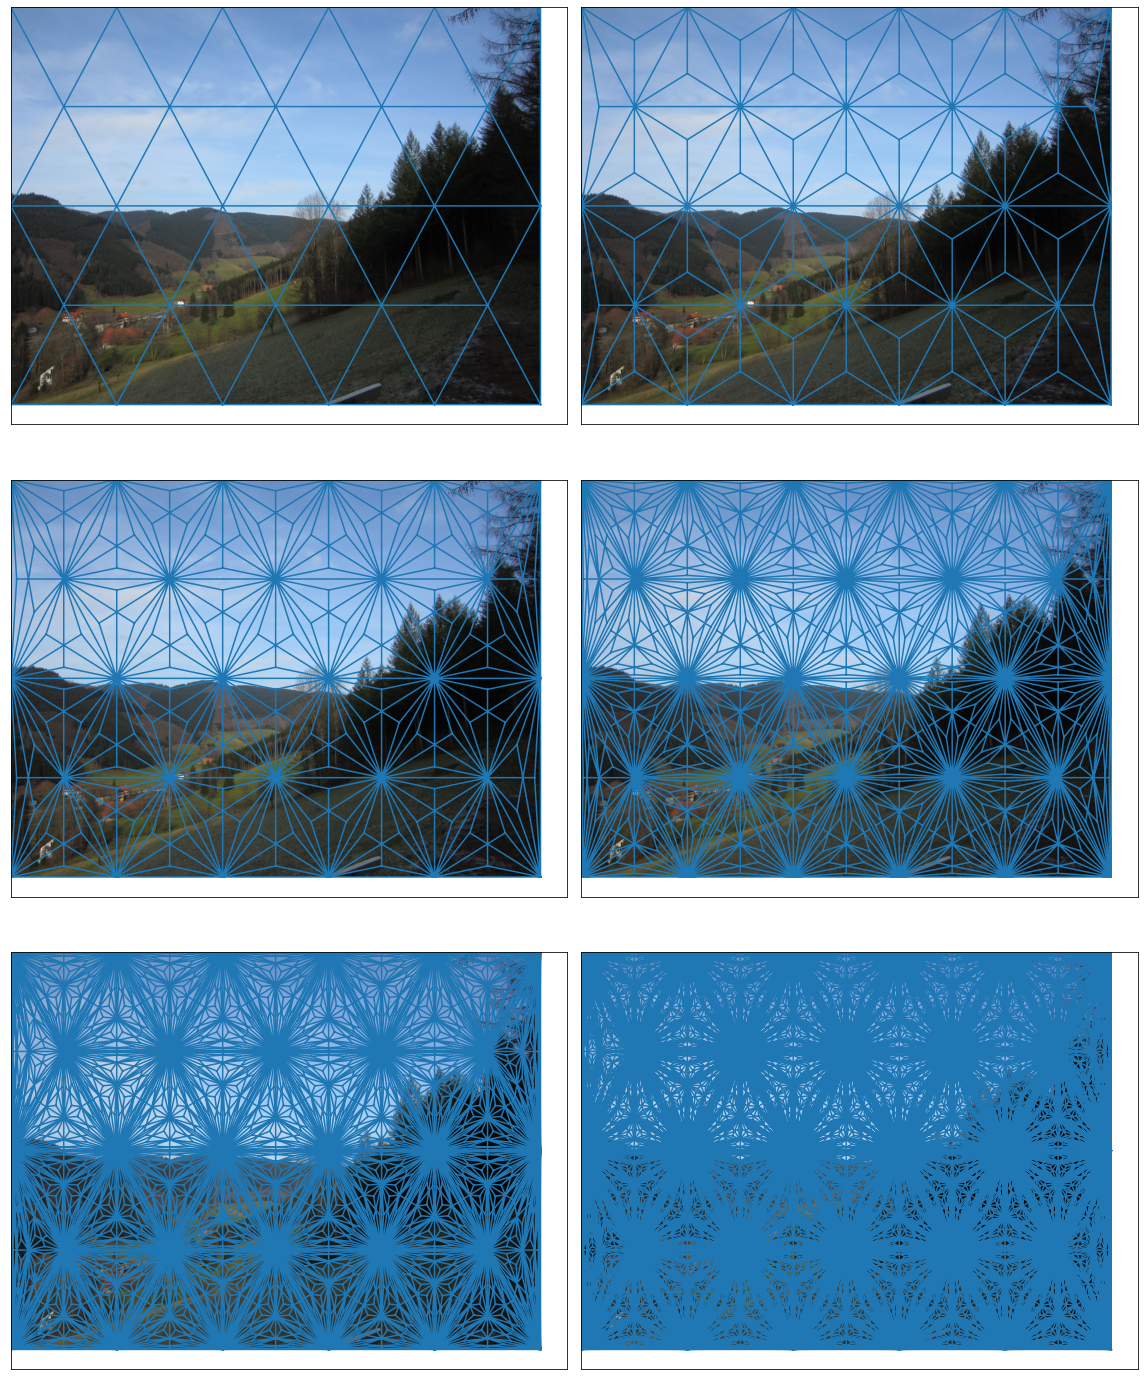

In [9]:
plt.close('all')

Nx = 5
Ny = 4

tri0 = hex_triangulation(img.shape, Nx=Nx, Ny=Ny, fill_edges=False)

tris = [tri0]
for ind in range(5):
    tris.append(refine_each_triangle_to_3(tris[-1]))
    
fig, axs = plt.subplots(ncols=2, nrows=3, figsize=(16, 20))

axs = axs.flatten()

for ind in range(6):
    myimshow(img, ax=axs[ind])
    axs[ind].triplot(tris[ind])
    
plt.tight_layout()

# IDEA 

It would be fun to use a crazy triangulation to create a paint (color) by numbers.

This could be done digitally, or you could print it out and color by hand.

## Now we need a way to assign heights to a given triangulation.

We can do this very generally, but we probably want some methods for producing something with symmetry or that have nice engineering features.

- We might want each triangle to have at least one (or two??) vertices at ground level.
- 

Let's just try some things out.


In [10]:
def mask_by_degree(tri, d):
    """Return a mask that shows only those vertices with a chosen degree `d`."""
    
    # Compute the degree of each point.
    # ravel combines all triangle triples into a single array.
    # bincount counts each occurrence (of each point index)
    # logic looks for where that count is the desired degree
    pt_inds = (np.bincount(tri.triangles.ravel()) == d)

    return pt_inds

## Use the mask to highlight only degree 3 points.

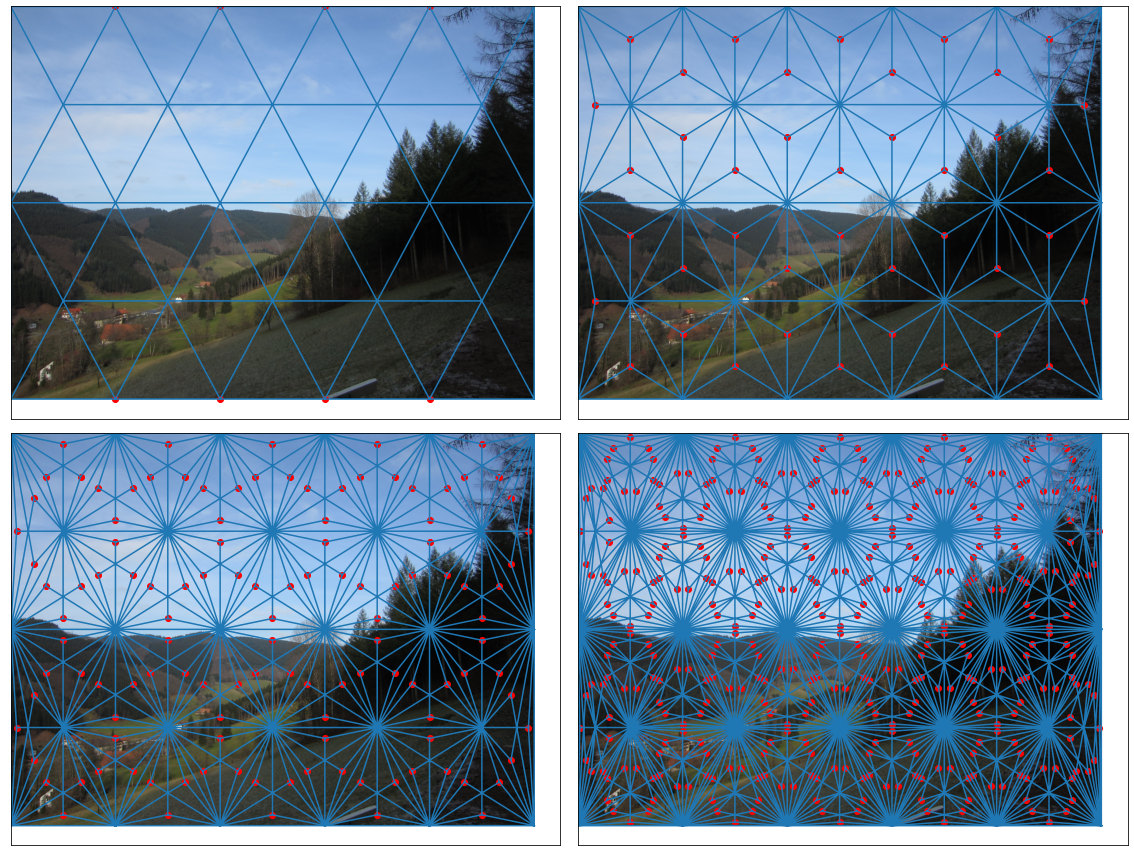

In [11]:
plt.close('all')

Nx = 5
Ny = 4

tri0 = hex_triangulation(img.shape, Nx=Nx, Ny=Ny, fill_edges=False)

tris = [tri0]
for ind in range(3):
    tris.append(refine_each_triangle_to_3(tris[-1]))
    
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(16, 12))

axs = axs.flatten()

for ind in range(4):
    myimshow(img, ax=axs[ind])
    axs[ind].triplot(tris[ind])
    
    pt_inds = mask_by_degree(tris[ind], 3)
    axs[ind].scatter(tris[ind].x[pt_inds], tris[ind].y[pt_inds], c='r')
    
plt.tight_layout()


## Apply a height function to the chosen points.

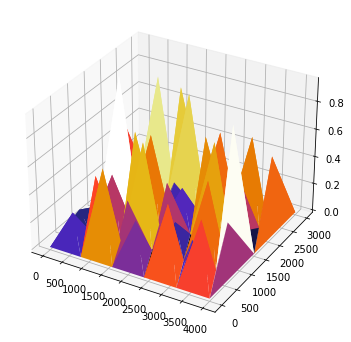

In [12]:
plt.close('all')

Nx = 5
Ny = 4

tri0 = hex_triangulation(img.shape, Nx=Nx, Ny=Ny, fill_edges=False)
tri1 = refine_each_triangle_to_3(tri0)

pt_inds = mask_by_degree(tri1, 3)

zs = np.asarray(pt_inds, dtype=float)
zs *= np.random.random(zs.shape)

fig = plt.figure(figsize=(8, 6))

ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.plot_trisurf(tri1, zs, cmap=plt.cm.CMRmap)

## Now prepare all stretched triangles to print.

Now that we have triangulated images, and the ability to stretch each triangle image appropriately, we need to lay out all of these triangles in some moderately compact form so that we can print them (and then cut them out).

TODO: Are the subplots of the correct scale?

mpl.subplots seems like the wrong path for getting a printable layout.
What are some other options? tikz?

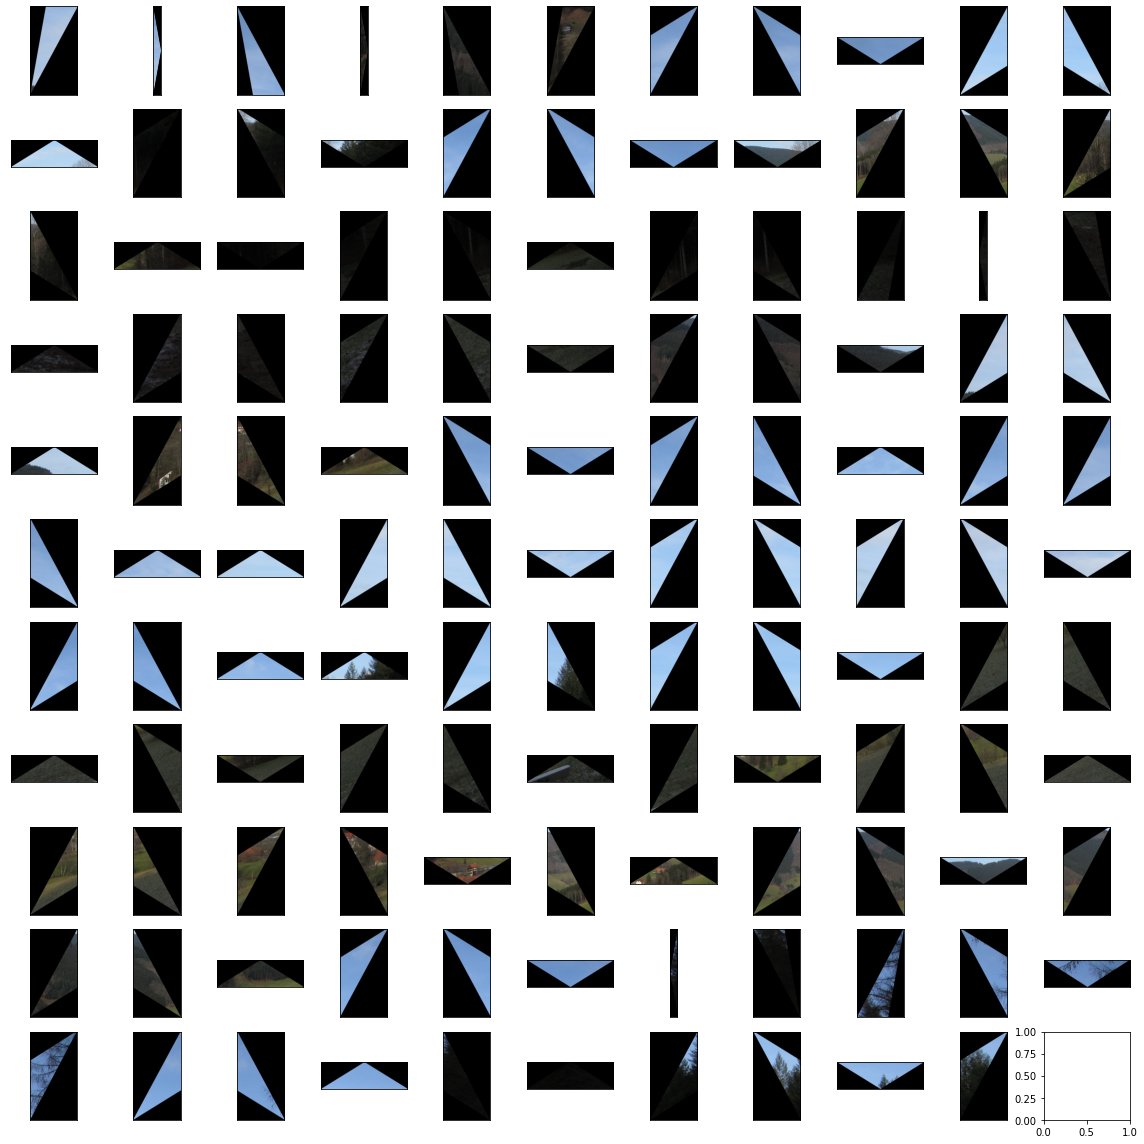

In [39]:
plt.close('all')

Nx = 5
Ny = 4

tri0 = hex_triangulation(img.shape, Nx=Nx, Ny=Ny, fill_edges=False)
tri1 = refine_each_triangle_to_3(tri0)

pt_inds = mask_by_degree(tri1, 3)

zs = np.asarray(pt_inds, dtype=float)
zs *= np.random.random(zs.shape)

num_triangles = len(tri1.triangles)

fig, axs = plt.subplots(nrows=int(np.ceil(num_triangles**0.5)), ncols=int(np.ceil(num_triangles**0.5)), figsize=(16, 16))

axs = axs.flatten()

for tind, tr in enumerate(tri1.triangles):
    tx = tri1.x[tr]
    ty = tri1.y[tr]

    tri3D = np.column_stack((tx, ty, tz))
    
    skewed_tri = get_skewed_triangle_image(img, tri3D)
    myimshow(skewed_tri, ax=axs[tind])
    
plt.tight_layout()